# Digital sheet music analyzer

## 1 Setting environments and importing necessary packages

### Installing MuseScore 3 is necessary for visualization purposes

Download link: https://musescore.org/en/download

In [1]:
 pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


The filename, directory name, or volume label syntax is incorrect.


In [10]:
import re
import math
import numpy as np
from itertools import chain
from collections import Counter
import nltk
from nltk.util import ngrams 
from music21 import *
from pathlib import Path 
import pandas as pd
import os 
from os import listdir
from os.path import isfile, join
from itertools import groupby
import glob
from difflib import SequenceMatcher
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import display, Markdown, clear_output
# widget packages
from ipywidgets import widgets, interact
from tqdm.notebook import trange, tqdm

from tkinter import Tk, filedialog
us = environment.UserSettings()

#Only for Windows - install and add your path of MuseScore3 here
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']

WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

## 2 Algorithms for extracting information from digital sheet note

#### Function to convert fraction objects to floats

In [3]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        decimal = whole - frac if whole < 0 else whole + frac
        return round(decimal,3)

### Extracts measure information from sheet parts

In [4]:
def get_measure_and_notes(part):
    measures = []
    detailed_seq = [] #Whole note part sequence without meassure markings
    for e in part.getElementsByClass('Measure'):
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements)
        
        for elem in newMeasure[e.number]:
            off_s = elem.offset
            if elem.isNote:
                
                if not isinstance(elem.duration.quarterLength, float) or not isinstance(off_s, float):
                    
                    decimal_lenght = convert_to_float(str(elem.duration.quarterLength))
                    off_s = convert_to_float(str(off_s))
                    detailed_seq.append((e.number, str(elem.pitch.midi), decimal_lenght, off_s))
                   
                else:
                    
                    detailed_seq.append((e.number, str(elem.pitch.midi), elem.duration.quarterLength, off_s))
                
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                notes = []
                
                for c in elem.notes:
                    if not isinstance(c.duration.quarterLength, float) or not isinstance(off_s, float):
                        decimal_lenght = convert_to_float(str(c.duration.quarterLength))
                        off_s = convert_to_float(str(off_s))
                        notes.append((e.number, str(c.pitch.midi),decimal_lenght, off_s))
                    else:
                        notes.append((e.number, str(c.pitch.midi), c.duration.quarterLength, off_s))
                        
                detailed_seq.append(notes)
            elif elem.isRest:
                detailed_seq.append((e.number, str(elem.name) + '_'+ str(elem.duration.quarterLength)))
        
        measures.append(newMeasure)

    
    dic = {}
    
    for i in range(len(detailed_seq)):
        if len(detailed_seq[i]) != 0:
            dic[i] = detailed_seq[i]
    return dic


MIDI = 64 -> MIDI TO NOTE -> note.Note(elem.pitch.midi).nameWithOctave (E4) - note type

### Sheet note information is extracted to datatable

In [5]:
def gather_part_info(note, noteName, sheet_path, note_id):
    allNote = [] #Every part of the instrument is collected here
    part_count = 1
    for el in note.elements: #Every part is a separately analyzed -> el = PartStaff
        #Basic info
        partList = {}
        partList['note_id'] = note_id
        partList['note_part_id'] = str(note_id) + "_" + str(part_count)
        partList['sheet_name'] = noteName
        partList['sheet_path'] = sheet_path
        partList['partName'] = el.partName 
        partList['sharps'] = el[1].keySignature.sharps #1. taktist saab helistiku märgid kätte.
        
        part_count +=1
        #Find the key
        try:
            if el.analyze('Krumhansl') == el.analyze('AardenEssen'):
                partList['key'] = el.analyze('Krumhansl').name  #MusicXML enda tuvastusalgoritm (ei ole alati täpne)
            else:
                partList['key'] = str(el.analyze('Krumhansl').name) + "  /  " +  str(el.analyze('AardenEssen')) #TODO: Check against dictionary
        except:
            partList['key'] = "None"
            
        #Find time signature
        time_signatures = []
        for i in (el['TimeSignature']):
            time_signatures.append(str(i.numerator) + '/' + str(i.denominator))
        if len(set(time_signatures)) == 0:
            partList['time_signature'] = "None"
        elif len(set(time_signatures)) == 1:
            partList['time_signature'] = time_signatures[0]
        else:
            partList['time_signature'] = set(time_signatures)
        
        #Find the Metronome
        metronome = []
        for i in el['MetronomeMark']: #TODO: Check against dictionary
            metronome.append(str(i.number))
        if len(set(metronome)) == 0:
            partList['bpm (quarter note)'] = "None" #MuseScore gives a default of 120.
        elif len(set(metronome)) == 1:
            partList['bpm (quarter note)'] = metronome[0]
        else:
            partList['bpm (quarter note)'] = set(metronome)
            
        #Find the clef
        partList['clef'] = el[1].clef.name
        #Find the measures and their content
        partList['measures'] = get_measure_and_notes(el)
        
        allNote.append(partList)
    return allNote

### Sidenotes: 

Sheets may have textboxes before the partstaffs.

* sheet[0][0] - metadata

* sheet[1] -> 1.partStaff
* sheet[1][1] -> 1. partStaff 1. measure
* sheet[1][1][1] -> 1. partStaff 1. measure 'SystemLayout' 
* sheet[1][1][1] -> 1. partStaff 1. measure 'Trebleclef' 
* sheet[1][1][2] -> 1. partStaff 1. measure 'Keysignature'
* sheet[1][1][3] -> 1. partStaff 1. measure 'Timesignature'
* sheet[1][1][4] -> 1. partStaff 1. measure First Note / Chord
    - If chord then
      *   sheet[1][1][4][0] -> 1. partStaff 1. measure First Note, lower note
      *   sheet[1][1][4][1] -> 1. partStaff 1. measure First Note, upper note
      
      
      
* len(c.flatten().getElementsByClass(chord.Chord)) - get all the chord elements of entire sheet
* len(c.flatten().getElementsByClass(note.Note)) - get all the note elements of entire sheet (no chord notes)

### Key change algoritm (to base key - C-major or a-minor)


* What method does note.transpose(i) use? - 

In [6]:
#Change all keys to either a-minor or C-major
def key_change_to_base(note): 
    
    k = note.analyze('key')
    
    if 'major' in str(k):
        i = interval.Interval(k.tonic, pitch.Pitch('c'))
    else:
        i = interval.Interval(k.tonic, pitch.Pitch('a'))
    sNew = note.transpose(i)
    kNew = sNew.analyze('key')
    
    return sNew

## 3 Importing sheet notes to dataframe

## Bach's corpus analysis 
#### (last index is 412)
### (.krn file is HUMDRUM tool KERN file - these files are not included)

In [33]:
def construct_bach_corpus_df(key_change):
    
    list_of_music = []
    paths = corpus.getComposer('bach')
    for i in paths:
        list_of_music.append(i.name)

    bach_notes = list_of_music[0:413]
    lst_note_info = []
    for note_idx in tqdm(range(len(bach_notes))):
        if '.mxl' in bach_notes[note_idx]:
            s = corpus.parse('bach/' + bach_notes[note_idx])
            if key_change:
                sNew = key_change_to_base(s)
                partStream2 = sNew.parts.stream()
            else:
                partStream2 = s.parts.stream()
            if len(lst_note_info) == 0:
                idx = 0
            else:
                idx = lst_note_info[-1]['note_id']

            note_info2= gather_part_info(partStream2, bach_notes[note_idx], 'corpus', idx+1)
            for elem in note_info2:
                lst_note_info.append(elem)

    df = pd.DataFrame(lst_note_info)
    return df
df_bach= df_whole = pd.DataFrame() 
print(len(df_bach))
df_complete = construct_bach_corpus_df(True)
df_complete


0it [00:00, ?it/s]

""


## 4 Longest Common Consequtive Non-overlapping Subsequence

#### Find the longest common, consequtive and non-overlapping subsequences between notes

### Sheet music information extracting and transformation algorithms for LCCNOSS analysis

#### Measures are assembled as following: - [a,b,c,d]

* a - measure nr. / index
* b - MIDI mark of the note (can retreive note pitch and note octave from it)
* c - duration of the note
* d - float = off-beat note/element, integer = on-beat note/element

### Removing rests

In [18]:
def remove_rests(lst):
    
    for el in lst:
        elem = el[1]
       
        if 'rest_' in elem[1]:
            lst.remove(el)
    return lst

### Removing off-beat notes

In [19]:
def remove_offbeat(lst):
    lst_new = remove_rests(lst)
    new_lst = []
    for el in lst_new:
        elem = el[1]
       
        if isinstance(elem, list):
            if elem[0][-1].is_integer():
                new_lst.append((el[0],elem))
        else:
            
            if type(elem[-1]) == str:
                lst_new.remove(el)
            else:
                
                if elem[-1].is_integer():
                    new_lst.append((el[0], elem))
    return new_lst

### Removing repetitive notes

In [20]:
def remove_repetitive_notes(lst):
    
    return [x[0] for x in groupby(lst)]


### Construct the string from note information

For [3] and [4] - they show the index positionis from where the list should be split.

**Possible values of variables:**

* n -> measure list from dataframe row
* if_rest -> True: keep the rests, False: remove the rests
* if_chords -> True: keep the chords, False: remove the chords and keep only the highest note of the chord
* m = 0 -> if measure nr IS taken into account OR m = 1 -> if measure nr is NOT taken into account
* o = 2 -> if note duration is NOT taken into account OR o = 3 -> if note duration IS taken into account
* offset -> True: keep the offset notes, False: remove offset notes 
* repetition -> True: keep the repetitive notes, False: remove the repetitive (aka consequtive same) notes

In [21]:
lst = []

def construct_strings(n, if_rest, if_chords, m, o, offset, repetition):
    
    n = ([(k, n[k]) for k in n]) #change dict to list value
    
    #Remove repetition first if needed
    if repetition == False:
        n = remove_repetitive_notes(n)
        
    lst = []
    lst_keys = []
    if offset == False: 
        n = remove_offbeat(n)
    
    for el in n:
        i = el[1]
        if if_rest == False:
            if 'rest' in i[1]:
                continue #skipping rests
        if isinstance(i, list):
            if if_chords == False: #Takes the first note of the chord into account
                elem = i[0][m:o]
                s = ' '.join(map(str,elem))
                lst.append(s)
                lst_keys.append(el[0])
            else: #Takes the whole chord into account
                cover_lst = []
                for elem in i:

                    elem = elem[m:3]
                    cover_lst.append(elem)
                s = ' '.join(map(str,cover_lst))
                lst.append(s)
                lst_keys.append(el[0])
        else:
            if 'rest' in i[1]:
                i = i[m:2]
                s = ' '.join(map(str,i))
                lst.append(s)
                lst_keys.append(el[0])
            else:
                i = i[m:o]
                s = ' '.join(map(str,i))
                lst.append(s)
                lst_keys.append(el[0])
   
    return lst, lst_keys

#TEST:
#for i in range(len(df)):
#a = construct_strings(dic, if_rest = False, if_chords =True,m=1, o=3, offset=True, repetition=False) 
#b = construct_strings(df['measures'][4], False, True, 1, 2, False, True)


### Generating n-grams and matching sequences - O(N²) — Quadratic Time:

In [22]:
def generate_ngrams(s, n):
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    
    ngrams = zip(*[s[i:] for i in range(n)])

    return [ngram for ngram in ngrams]

def match_seq(list1,list2):
    output=[]
    s = SequenceMatcher(None, list1, list2)
    #print(round(s.ratio(), 2))
    blocks=s.get_matching_blocks()
    for bl in blocks:
        for bi in range(bl.size):
            cur_a=bl.a+bi
            cur_b=bl.b+bi
            output.append((cur_a,cur_b))
    return output

def matched_seq_analysis(a, b, ngram, a_keys, b_keys):
    
    matched_seq=[]
    
    a_gram = generate_ngrams(a,ngram)
    b_gram = generate_ngrams(b,ngram)
    
    
    for x,y in match_seq(a_gram,b_gram): #x and y represent the 'order number of the specific note'
        
        k = list(a_gram[x])
        k2 = list(b_gram[y])
        
        idxs_a = [(i, i+len(k)) for i in range(len(a)) if a[i:i+len(k)] == k]
        idxs_b = [(i, i+len(k2)) for i in range(len(b)) if b[i:i+len(k2)] == k2]
        
        a_gram_keys = a_keys[idxs_a[0][0]:idxs_a[0][1]]
        b_gram_keys = b_keys[idxs_b[0][0]:idxs_b[0][1]]
        
        matched_seq.append((x,y, a_gram[x],b_gram[y], a_gram_keys, b_gram_keys))
        
    return matched_seq

## Find Different Longest Consecutive Non-Overlapping Subsequences between two strings

### Finding the longest common subsequence (starting from 4-gram)

In [23]:
def LCCNOS(n1, n2, if_rest, if_chords, m, o, offset, repetition):
    a = construct_strings(n1, if_rest, if_chords, m, o, offset, repetition) 
    b = construct_strings(n2, if_rest, if_chords, m, o, offset, repetition)
    
    lst_of_matched_seqs = []
    counter = 4 #Starting to look for ngrams 4 and above
    total_matches = []
    if len(n1) > len(n2):
        
        total = len(n2)
        total_matches = []
        while counter != total: 
            matched = matched_seq_analysis(a[0], b[0], counter, a[1], b[1])
            if len(matched) == 0:
                break
            else:
                total_matches = matched
                
            counter +=1 
    else:
        total = len(n1)
        total_matches = []
        while counter != total:
            matched = matched_seq_analysis(a[0],b[0], counter, a[1], b[1])
            if len(matched) == 0:
                break
            else:
                total_matches = matched
               
            counter +=1 
        
    if len(total_matches) == 0:
        return 0, 0, 0
    else:
        idx1 = total_matches[0][0]
        idx2 = total_matches[0][1]
        seq_length = len(total_matches[0][3])

        found_matches = []

        range_1 = list(range(idx1, idx1+(counter-1)))
        range_2 = list(range(idx2, idx2+(counter-1)))

        while seq_length > 4:
            if len(found_matches) == 3:
                break
            matched = matched_seq_analysis(a[0], b[0], seq_length, a[1], b[1])

            for match in matched:

                if match[0] not in range_1 and match[1] not in range_2:
                    found_matches.append(match)
                    range_1 = range_1 + list(range(match[0], match[0]+seq_length))
                    range_2 = range_2 + list(range(match[1], match[1]+seq_length))
                    range_1.sort()
                    range_2.sort()
            seq_length= seq_length - 1
                
        if len(found_matches) == 0:
            found_matches = 0
    
    
        
        return total_matches, len(total_matches[0][3]), found_matches 

## Matching the longest common sequences

### Ways of doing:

* Rests:<br>
   a) Keep the rests in the note sequeneces <br>
   b) Remove all the rests from the note sequences <br><br>

* Chords<br>
a) Leave chords as they are - KITSENDUS (võimalik oleks ka kõik akordi noodid lisada või siis määrata ära akordi tähtsaim noot? -> .root()) <br>
b) Only take account the first note (higher note) of the chord (chord can be harmony starting from 2 consequently sounding notes)<br><br>

* Measure nr<br>
a) Consider the specific measure number - meaning that the parts must align<br>
b) Do not consider measure number - similar sequences can be see throughout the part<br><br>

* Note duration<br>
a) Consider note duration in the sequence matching<br>
b) Do not consider note duration (note can be in any duration as long as it is the same consequtive note - then it will match)<br><br>

* Offset notes<br>
a) Leave offset (not on beat notes) into the sheet<br>
b) Remove all notes that do not fall on beat<br><br>

* Repetition <br>
a) Same consequitive notes are kept<br>
b) Same consequtive notes are removed<br>

### Datatable   
   
LCCNOS = Longest Common Consequtive Non-Overlapping Sequence

### Construct the rules for LCCNOS method

In [24]:
def construct_LCCNOS(df_base, i, y, complete):
    
    helper_dictionary = {0: 'Yes', 1: 'No', 2: 'No', 3: 'Yes'}
    #Test for only one LCS method
    if not complete:
        
        key = str(df_base['note_part_id'][i] + ' + ' + df_base['note_part_id'][y])
        
        #Example method - change it and choose your own
        LCS_x, l, lccnos = LCCNOS(df_base['measures'][i],df_base['measures'][y], True, False, 0, 3, True, False)
        
        data = {'Notes': key,'LCS': LCS_x, 'lenght': l, 'LCCNOS': lccnos, 'rests':True,'chords':False, 'consider_measure_idx':helper_dictionary[0],
                                   'consider_note_duration':helper_dictionary[2], 'offset_notes':True, 'repetition':False}
        
        print(data)
       
        
        df_whole = pd.DataFrame(data, index=[0])

        
    else:
        #Computes all the possible method variants
        rests = [True, False]
        chords = [True, False]
        measure_idx = [0,1]
        note_duration = [2,3]
        offset_notes = [True, False]
        repetition = [True, False]

        lst_of_rows =[]
        for a in rests:
            for b in chords:
                for c in measure_idx:
                    for d in note_duration:
                        for e in offset_notes:
                            for f in repetition:

                                method = str(a)[0]+str(b)[0]+helper_dictionary[c][0]+helper_dictionary[d][0]+str(e)[0]+str(f)[0]
                                
                                key = str(df_base['note_part_id'][i] + ' + ' + df_base['note_part_id'][y])
                                
                                LCS_x, l, lccnos = LCCNOS(df_base['measures'][i],df_base['measures'][y],a,b,c,d,e,f)
                                
                                data = {'Notes': key,'LCS': LCS_x, 'lenght': l, 'LCCNOS':lccnos, 'method_id':method, 'rests':a,'chords':b, 'consider_measure_idx':helper_dictionary[c],
                                       'consider_note_duration':helper_dictionary[d], 'offset_notes':e, 'repetition':f}
                                
                                lst_of_rows.append(data)
        df_whole = pd.DataFrame(lst_of_rows)
                        
    return df_whole

In [27]:
#Look for similar sequence between two different notes OR against all the notes in the dataframe
def LCCNOS_analysis(df_base, i, one_note_bool, if_complete):
    df_whole = pd.DataFrame()

    note_dict = {}
    if one_note_bool != -1: #Compare to all the notes in the dataframe
        
        y =  one_note_bool
        df_whole = construct_LCCNOS(df_base, i, y, if_complete)
        
    else: #Compare to specific note in the dataframe (based on index)
        for y in range(len(df_base)):
            if i !=y:
                df_part = construct_LCCNOS(df_base, i, y, if_complete)
                
                df_whole = df_whole.append(df_part, ignore_index = True) #append is computationally bad!
    return df_whole

### Import note you want to compare against the dataframe notes

In [12]:
from tkinter import messagebox
root = Tk()
root.withdraw() #use to hide tkinter window
def search_for_file_path():
    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True) 
    currdir = os.getcwd()
    tempfile = filedialog.askopenfilename(parent=root, initialdir=currdir, title='Please select a .mxl file')

    if tempfile=='':
        return messagebox.showinfo("Faili avamine", "Ühtegi faili ei valitud või fail on tühi. Vali MusicXML-fail")
    elif  tempfile.lower().endswith(('.musicxml', '.mxl')) == False:
        return messagebox.showinfo("Vale fail", "Sisestatud fail on vale, sisesta MusicXML-fail.")
    else:
        print ("You chose: %s" % tempfile)
    return tempfile


file_path_variable = search_for_file_path()

You chose: C:/Users/Lleis/Documents/SCHOOL/digimagister/digital_sheet_music_analysis/covers_notes/Fur_Elise (1).mxl
C:/Users/Lleis/Documents/SCHOOL/digimagister/digital_sheet_music_analysis/covers_notes/Fur_Elise (1).mxl


In [28]:
#for i in tqdm(range(1, len(df_complete), 1)):  # For loops

#ADD the note index here what you want to compare:
i = 4   
df_whole = LCCNOS_analysis(df, i, 4, True) #-1 if you want to analyze all the notes
df_whole

,Notes,LCS,lenght,LCCNOS,method_id,rests,chords,consider_measure_idx,consider_note_duration,offset_notes,repetition
0,3_1 + 3_1,"[(0, 0, (1 76, 1 75, 1 76, 1 75, 1 76, 1 75, 2...",92,0,TTYNTT,True,True,Yes,No,True,True
1,3_1 + 3_1,"[(0, 0, (1 76, 1 75, 1 76, 1 75, 1 76, 1 75, 2...",92,0,TTYNTF,True,True,Yes,No,True,False
2,3_1 + 3_1,"[(0, 0, (1 76, 1 76, 1 76, 2 76, 2 76, 2 74, 3...",49,0,TTYNFT,True,True,Yes,No,False,True
3,3_1 + 3_1,"[(0, 0, (1 76, 1 76, 1 76, 2 76, 2 76, 2 74, 3...",49,0,TTYNFF,True,True,Yes,No,False,False
4,3_1 + 3_1,"[(0, 0, (1 76 0.5, 1 75 0.5, 1 76 0.5, 1 75 0....",92,0,TTYYTT,True,True,Yes,Yes,True,True
...,...,...,...,...,...,...,...,...,...,...,...
59,3_1 + 3_1,"[(0, 0, (76, 76, 76, 76, 76, 74, 69, 71, 68, 7...",49,0,FFNNFF,False,False,No,No,False,False
60,3_1 + 3_1,"[(0, 0, (76 0.5, 75 0.5, 76 0.5, 75 0.5, 76 0....",87,0,FFNYTT,False,False,No,Yes,True,True
61,3_1 + 3_1,"[(0, 0, (76 0.5, 75 0.5, 76 0.5, 75 0.5, 76 0....",87,0,FFNYTF,False,False,No,Yes,True,False
62,3_1 + 3_1,"[(0, 0, (76 0.5, 76 0.5, 76 0.5, 76 0.5, 76 0....",49,0,FFNYFT,False,False,No,Yes,False,True


### Clean and transform the resulted dataframe

In [29]:
df_whole_small = df_whole.sort_values('lenght', ascending=False)
df_whole_small[:29]

,Notes,LCS,lenght,LCCNOS,method_id,rests,chords,consider_measure_idx,consider_note_duration,offset_notes,repetition
0,3_1 + 3_1,"[(0, 0, (1 76, 1 75, 1 76, 1 75, 1 76, 1 75, 2...",92,0,TTYNTT,True,True,Yes,No,True,True
9,3_1 + 3_1,"[(0, 0, (76, 75, 76, 75, 76, 75, 76, 75, 76, 7...",92,0,TTNNTF,True,True,No,No,True,False
17,3_1 + 3_1,"[(0, 0, (1 76, 1 75, 1 76, 1 75, 1 76, 1 75, 2...",92,0,TFYNTF,True,False,Yes,No,True,False
16,3_1 + 3_1,"[(0, 0, (1 76, 1 75, 1 76, 1 75, 1 76, 1 75, 2...",92,0,TFYNTT,True,False,Yes,No,True,True
1,3_1 + 3_1,"[(0, 0, (1 76, 1 75, 1 76, 1 75, 1 76, 1 75, 2...",92,0,TTYNTF,True,True,Yes,No,True,False
13,3_1 + 3_1,"[(0, 0, (76 0.5, 75 0.5, 76 0.5, 75 0.5, 76 0....",92,0,TTNYTF,True,True,No,Yes,True,False
12,3_1 + 3_1,"[(0, 0, (76 0.5, 75 0.5, 76 0.5, 75 0.5, 76 0....",92,0,TTNYTT,True,True,No,Yes,True,True
24,3_1 + 3_1,"[(0, 0, (76, 75, 76, 75, 76, 75, 76, 75, 76, 7...",92,0,TFNNTT,True,False,No,No,True,True
20,3_1 + 3_1,"[(0, 0, (1 76 0.5, 1 75 0.5, 1 76 0.5, 1 75 0....",92,0,TFYYTT,True,False,Yes,Yes,True,True
25,3_1 + 3_1,"[(0, 0, (76, 75, 76, 75, 76, 75, 76, 75, 76, 7...",92,0,TFNNTF,True,False,No,No,True,False


In [ ]:
#Saving results to csv
#df_whole_small.to_csv('bach_analysis_2.csv')

## 4 Visualization

### Algorithms for visualizing subs

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_subs(name1, name2, part_id_1, part_id_2, seq1, seq2):
    
    #if it's a Bach corpus note or note from local directory
    if 'bwv' in name1:
        s1 = corpus.parse('bach/'+name1)
    else:
        s1 = converter.parse(name1)
        
    if 'bwv' in name2:
        s2 = corpus.parse('bach/'+name2)
    else:
        s2 = converter.parse(name2)
    
    sNew1 = key_change_to_base(s1)
    partStream1 = sNew1.parts.stream()
    sNew2 = key_change_to_base(s2)
    partStream2 = sNew2.parts.stream()
    
    print(seq1)
    print(seq2)
    sNew1.parts[int(part_id_1)-1].measures(seq1[0][0],seq1[-1][0]).show()
    sNew2.parts[int(part_id_2)-1].measures(seq2[0][0],seq2[-1][0]).show()
    
    sNew1.parts[int(part_id_1)-1].measures(seq1[0][0],seq1[-1][0]).show('midi')
    sNew2.parts[int(part_id_2)-1].measures(seq2[0][0],seq2[-1][0]).show('midi')
    
    
    return sNew1.parts[int(part_id_1)-1].measures(seq1[0][0],seq1[-1][0]).plot().run(), sNew2.parts[int(part_id_2)-1].measures(seq2[0][0],seq2[-1][0]).plot().run()

## References back to original notes 

C:/Users/Lleis/Documents/SCHOOL/digimagister/digital_sheet_music_analysis/covers_notes\Fur_Elise (1).mxl
C:/Users/Lleis/Documents/SCHOOL/digimagister/digital_sheet_music_analysis/covers_notes\Fur_Elise (1).mxl
[(1, '76', 0.5, 0.0), (1, '75', 0.5, 0.5), (1, '76', 0.5, 1.0), (1, '75', 0.5, 1.5), (1, '76', 0.5, 2.0), (1, '75', 0.5, 2.5), (2, '76', 0.5, 0.0), (2, '75', 0.5, 0.5), (2, '76', 0.5, 1.0), (2, '71', 0.5, 1.5), (2, '74', 0.5, 2.0), (2, '72', 0.5, 2.5), (3, '69', 2.0, 0.0), (3, 'rest_0.5'), (3, '69', 0.5, 2.5), (4, '71', 2.0, 0.0), (4, '68', 0.5, 2.0), (4, '71', 0.5, 2.5), (5, '72', 3.0, 0.0), (6, '76', 0.5, 0.0), (6, '75', 0.5, 0.5), (6, '76', 0.5, 1.0), (6, '75', 0.5, 1.5), (6, '76', 0.5, 2.0), (6, '75', 0.5, 2.5), (7, '76', 0.5, 0.0), (7, '75', 0.5, 0.5), (7, '76', 0.5, 1.0), (7, '71', 0.5, 1.5), (7, '74', 0.5, 2.0), (7, '72', 0.5, 2.5), (8, '69', 2.0, 0.0), (8, 'rest_0.5'), (8, '69', 0.5, 2.5), (9, '71', 2.0, 0.0), (9, '72', 0.5, 2.0), (9, '71', 0.5, 2.5), (10, '69', 3.0, 0.0)

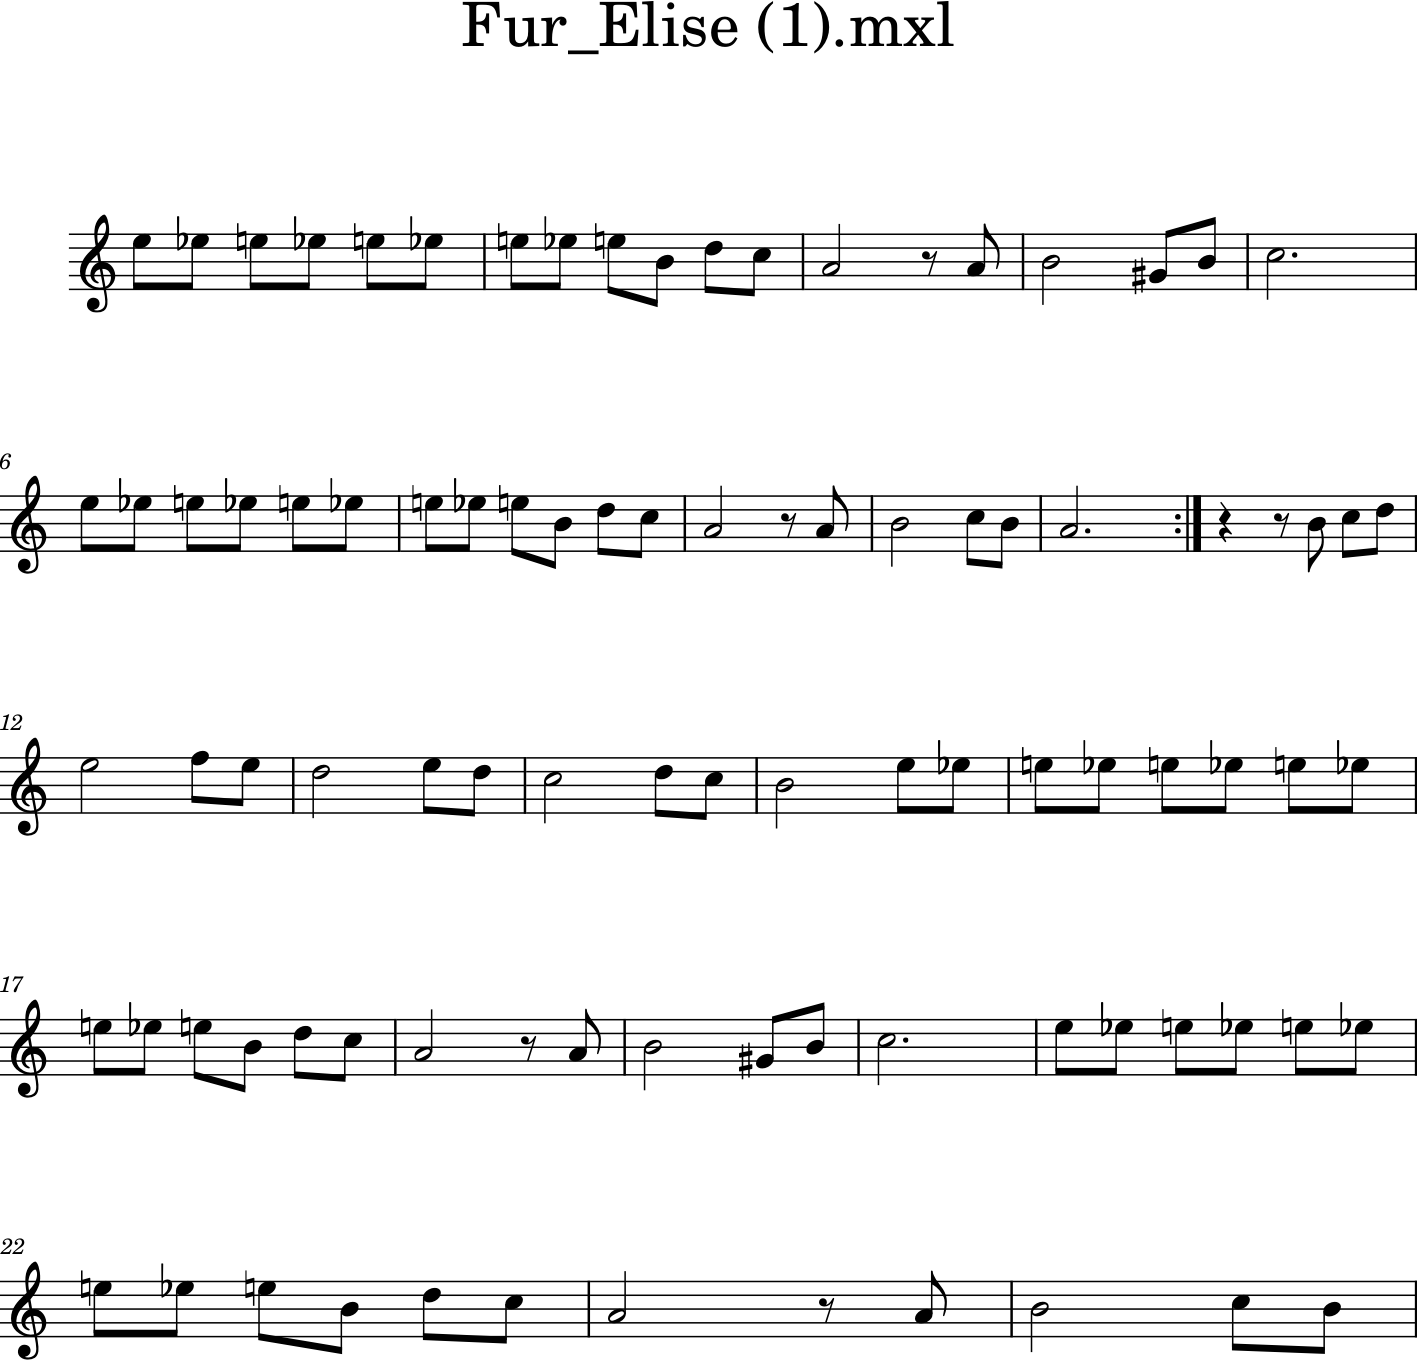

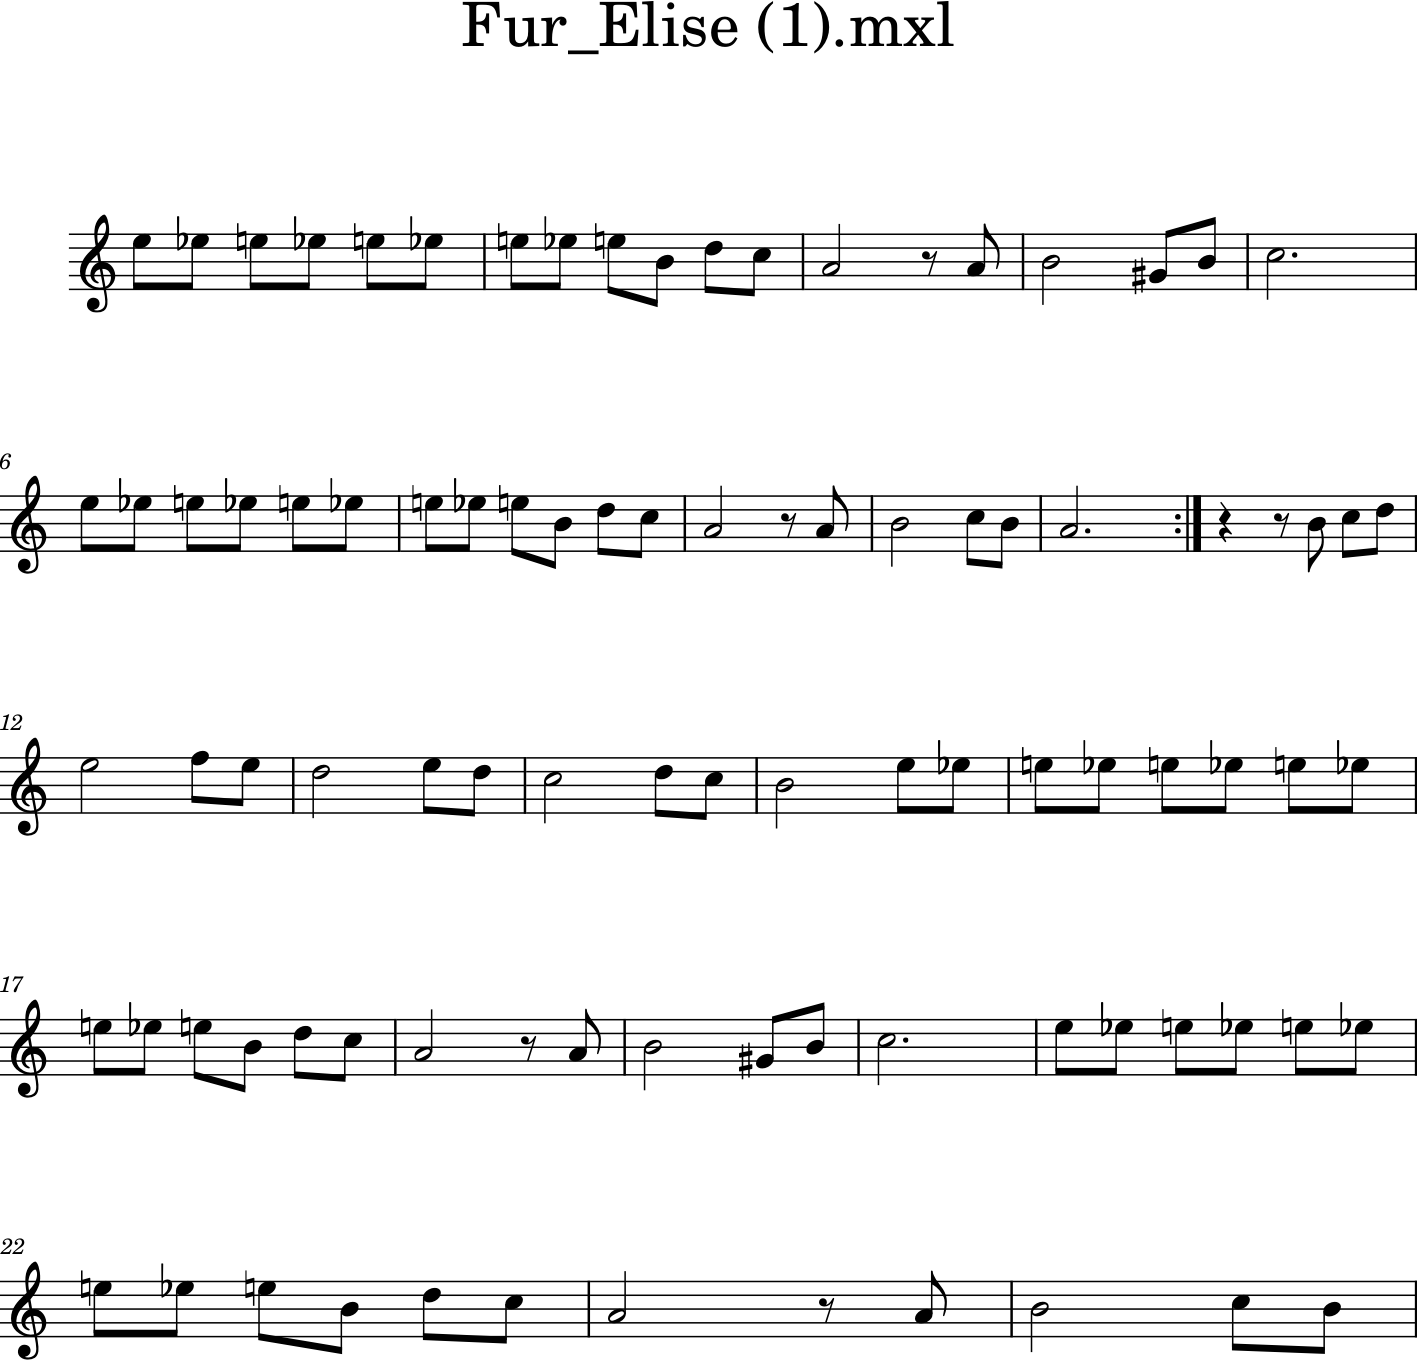

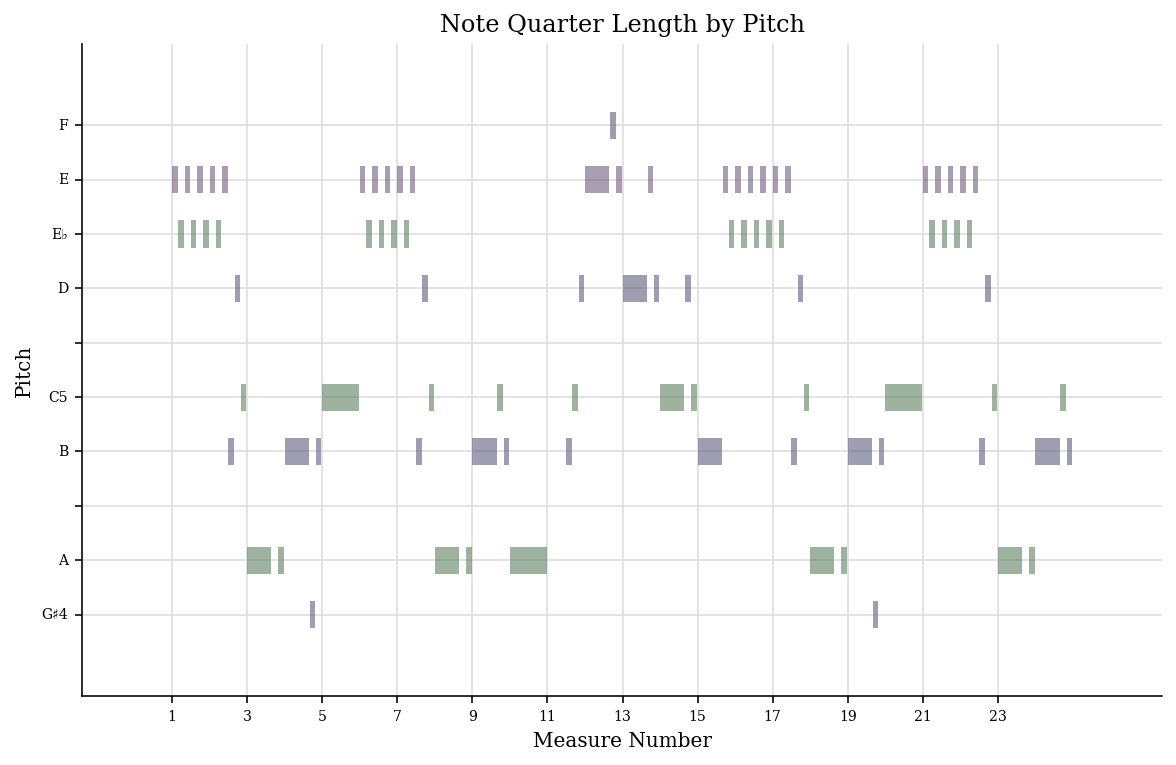

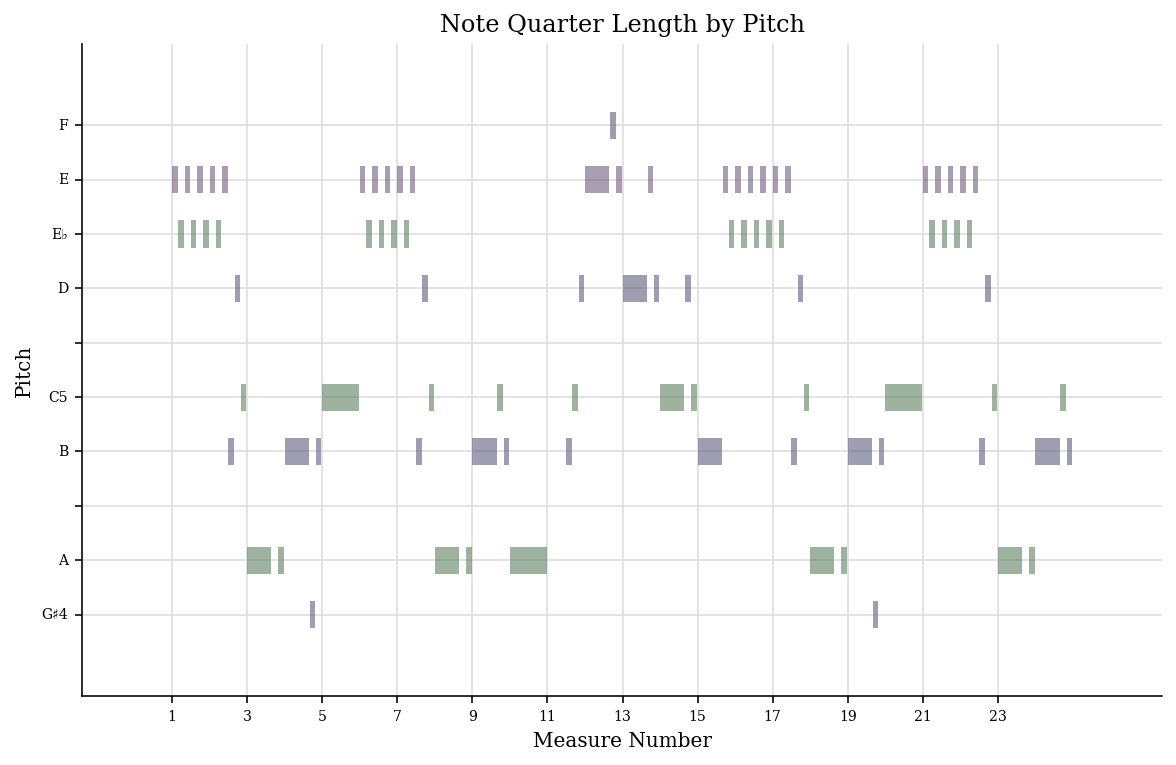

In [32]:
def separate_note_names(notes):
    
    splitted_note_names = notes.split()
   
    note1 = splitted_note_names[0]
    note2 = splitted_note_names[2]

    return note1, note2

def get_actual_notes(notes, idxs):
    
    actual_notes = []
    for i in idxs:
        actual_notes.append(notes[i])
    
    return actual_notes

def get_whole_actual_seq(notes, idxs):
    
    actual_seq = []
    
    start_id = idxs[0]
    end_id = idxs[-1]
    
    while start_id != end_id:
        actual_seq.append(notes[start_id])
        start_id= start_id +1 
      
    return actual_seq
        
def get_notes(notes, lcs, df_base):
    
    note1, note2 = separate_note_names(notes)
    part_a_measures = df_base.loc[df_base['note_part_id'] == note1]['measures'].values[0]
    part_b_measures = df_base.loc[df_base['note_part_id'] == note2]['measures'].values[0]
    
    
    part_a_notes_idxs  = lcs[0][4]
    part_b_notes_idxs  = lcs[0][5]
    
    part_a_actual_notes = get_actual_notes(part_a_measures,part_a_notes_idxs)
    part_b_actual_notes = get_actual_notes(part_b_measures,part_b_notes_idxs)
        
    part_a_actual_seq = get_whole_actual_seq(part_a_measures,part_a_notes_idxs)
    part_b_actual_seq = get_whole_actual_seq(part_b_measures,part_b_notes_idxs)
    
    if df_base['sheet_path'].values[0] == 'corpus':
        
        n1_name = df_base.loc[df_base['note_part_id'] == note1]['sheet_name'].values[0]
        n2_name = df_base.loc[df_base['note_part_id'] == note2]['sheet_name'].values[0]
        
    else:
        
        n1_name = df_base.loc[df_base['note_part_id'] == note1]['sheet_path'].values[0]
        n2_name = df_base.loc[df_base['note_part_id'] == note2]['sheet_path'].values[0]

    splitted_note_names = notes.split()
    
    part_id_1 = splitted_note_names[0].split('_')[-1]
    part_id_2 = splitted_note_names[2].split('_')[-1]
        
    print(n1_name)
    print(n2_name)
    visualize_subs(n1_name, n2_name, part_id_1, part_id_2, part_a_actual_seq, part_b_actual_seq)
    
#Change the row nr of the df_whole_small you want to analyze and add the original df.


get_notes(df_whole_small['Notes'].iloc[0], df_whole_small['LCS'].iloc[0], df)

### Algorithms for generating playback note sequences - is it needed?

In [ ]:
from music21 import *
class KeyToken(tinyNotation.Token):
    def parse(self, parent):
        keyName = self.token
        return key.Key(keyName)
    
def tiny_notes(part_name, seq1, df_base):
    dura_dict = {0.25:16, 0.5:8, 1.0:4, 2.0:2, 3.0: 1.5, 4.0:1}
    key = df_base.loc[df_base['note_part_id'] == part_name]['key'].values[0]
    time= df_base.loc[df_base['note_part_id'] == part_name]['time_signature'].values[0]
    notes = ''
    print(key)
    print(time)
    for i in seq1:
        print(i)
        n_oct = note.Note(int(i[1])).nameWithOctave
        n = note.Note(int(i[1])).name
        duration = i[2]
        
        if n_oct[-1] == '4':
            n = n.lower()
        elif int(n_oct[-1]) ==2:
            n = str(n)+str(n)
        elif int(n_oct[-1]) ==1:
            n = str(n)+str(n)+str(n)
        
        elif int(n_oct[-1]) == 5:
            n= str(n)+"'"
        elif int(n_oct[-1]) == 6:
            n= str(n)+"'"+"'"
        elif int(n_oct[-1]) == 7:
            n= str(n)+"'"+"'"+"'"
            
            
        duration = dura_dict[i[2]]

        notes = notes + str(n) + str(duration) + ' '
        print(notes)
    tinynote = str(time) + ' ' + 'k'+(str(key.lower()) + ' ' + notes)
    
    tnc = tinyNotation.Converter()
    keyMapping = (r'k(.*)', KeyToken)
    tnc.tokenMap.append(keyMapping)
    tnc.load(tinynote)
    tnc.parse()
    s = tnc.stream
    s.append(tempo.MetronomeMark(70))
    s.show()
    return s.show('midi')
    
#lst = df_base[df_base['note_part_id'] == '16_3']['measures'].values[0]
#print(lst)
#tiny = tiny_notes('16_3', lst)

### Add results to Excel file for further analysis

In [ ]:
df_whole.to_csv('whole_notes.csv')

## Checking differences between key transposing and interval analysis

In [177]:
def check_semitones(st_inter, intervals):
    if st_inter > 12:
        st_inter = st_inter % 12  
    elif st_inter < -12:
        st_inter = st_inter % -12
    intervals.append(st_inter)
    
def find_intervals(allInfo):
    intervals= []
    i=1 #Alustan 2. noodist, sest pean alati kontrollima, kas eelmine noot on noot või mitte.
    while i != len(allInfo) and len(allInfo) != 0 and len(allInfo) != 1:
       
        inter = interval.Interval(noteStart=allInfo[i-1], noteEnd=allInfo[i]).semitones
        check_semitones(inter,intervals)
            
        i+=1
    return intervals

def convert_to_interval(lst):
    n = ([(k, lst[k]) for k in lst])
    lst_1 = remove_rests(n)
    part_notes = []
    intervals = []
    
    
    for elem in lst_1:
        #print(elem)
        if isinstance(elem[1], list):
            continue
        elif 'rest' in elem[1][1]:
            continue
        else:
            n_int = int(elem[1][1])
        n = note.Note(n_int).nameWithOctave
        new_n = note.Note(n)
        part_notes.append(new_n)
    
    new_lst = find_intervals(part_notes)
    
    #print(new_lst)
    return new_lst
    


In [176]:
c5 = converter.parse(r'C:\Users\Lleis\Documents\SCHOOL\digimagister\digital_sheet_music_analysis\notes\Canon_in_D.mxl')
partStream2 = c5.parts.stream()
note_info2= gather_part_info(partStream2, 'int', 'test', 2)

#Add first note to the dataframe to create it
df_test = pd.DataFrame(note_info2)

print(c5.analyze('key'))
c5New = key_change_to_base(c5)

print(c5New.analyze('key'))
partStream3 = c5New.parts.stream()
idx = df_test['note_id'].iloc[-1]

note_info3= gather_part_info(partStream3, 'int_changed', 'test', idx+1)
df_new = pd.DataFrame(note_info3)

df_test= df_test.append(df_new, ignore_index = True)

df_test

D major
C major


,note_id,note_part_id,sheet_name,sheet_path,partName,sharps,key,time_signature,bpm (quarter note),clef,measures
0,2,2_1,int,test,Piano,2,D major,4/4,100.0,treble,"{0: (1, 'rest_4.0'), 1: (2, 'rest_4.0'), 2: (3..."
1,2,2_2,int,test,Piano,2,D major,4/4,100.0,bass,"{0: (1, '50', 0.5, 0.0), 1: (1, '57', 0.5, 0.5..."
2,3,3_1,int_changed,test,Piano,0,C major,4/4,100.0,treble,"{0: (1, 'rest_4.0'), 1: (2, 'rest_4.0'), 2: (3..."
3,3,3_2,int_changed,test,Piano,0,C major,4/4,100.0,bass,"{0: (1, '48', 0.5, 0.0), 1: (1, '55', 0.5, 0.5..."


In [148]:
df_test

,note_id,note_part_id,sheet_name,sheet_path,partName,sharps,key,time_signature,bpm (quarter note),clef,measures
0,2,2_1,int,test,Piano,-2,G minor / c minor,"{4/4, 3/8, 5/4, 3/4}","{75.0, 30.0, 10.0}",treble,"{0: (1, 'rest_4.0'), 1: (2, 'rest_4.0'), 2: (3..."
1,2,2_2,int,test,Piano,-2,G minor,"{4/4, 3/8, 5/4, 3/4}","{75.0, 30.0, 10.0}",bass,"{0: (1, '43', 0.5, 0.0), 1: (1, '50', 0.5, 0.5..."
2,3,3_1,int_changed,test,Piano,0,A minor / d minor,"{4/4, 3/8, 5/4, 3/4}","{75.0, 30.0, 10.0}",treble,"{0: (1, 'rest_4.0'), 1: (2, 'rest_4.0'), 2: (3..."
3,3,3_2,int_changed,test,Piano,0,A minor,"{4/4, 3/8, 5/4, 3/4}","{75.0, 30.0, 10.0}",bass,"{0: (1, '45', 0.5, 0.0), 1: (1, '52', 0.5, 0.5..."


In [178]:
converted_1 = convert_to_interval(df_test['measures'][0])
converted_2 = convert_to_interval(df_test['measures'][2])
print(converted_1==converted_2)

[-2, -2, -1, -2, -2, 2, 2, 1, 4, 3, -2, -1, -4, 4, -2, -2, -3, 3, 4, 1, 4, -2, -2, -1, 1, -5, 2, -5, 7, 5, -4, -5, -1, 1, -5, 0, 4, 1, 4, 3, 2, -4, -1, -2, 3, -1, -2, -2, -1, -2, -2, 5, 0, -1, 1, -1, 1, -5, 0, 4, 1, 4, 3, 2, -4, -1, -2, 3, -1, -2, -2, -1, -2, -2, 5, 0, -1, 1, -1, 1, -5, 4, -4, 7, 2, -4, 0, -1, -2, 2, 5, 3, 2, -4, -1, -2, 3, -1, -2, -2, -1, -2, -2, -2, -1, -2, 3, -1, -2, 10, 2, 2, 1, 2, -5, 5, -2, -1, 5, -2, -2, 2, -2, -1, -2, -2, -3, 0, 2, 1, 4, -2, -2, 4, 1, -5, -1, -2, 2, 1, -1, 8, -3, 1, 2, -3, 1, 2, -12, 2, 2, 1, 2, 2, 1, -1, -4, 2, 2, -12, 1, 2, 2, -2, -2, 2, -3, 1, 2, -2, 4, -2, -2, -1, -2, 2, -2, -2, 2, 2, 1, 2, 2, -4, 4, -2, 2, 2, 1, -5, 2, 2, 1, 2, 2, 1, 2, 0, -3, 1, 2, -3, 1, 2, -12, 2, 2, 1, 2, 2, 1, -1, -4, 2, 2, -12, 1, 2, 2, -2, -2, 2, -3, 1, 2, -2, 4, -2, -2, -1, -2, 2, -2, -2, 2, 2, 1, 2, 2, -4, 4, -2, 2, 2, 1, -5, 2, 2, 1, 2, 2, 1, 2, -3, -4, 2, 2, -2, -2, 2, -3, 1, 2, 2, -2, -2, -1, 1, -3, 2, 1, 0, 2, 2, 1, -1, -2, 2, -4, -1, 1, -3, 3, -1, -2, -2, -2,